In [1]:
## Notebook env: brian_script_env (R kernel)

## Run Finding_variable_genes_ipynb before running this script
### This script measures if a given guide's cells see increased or decreased
### gene expression heterogeneity compared to control cells)

### Coefficient of Variation (CV) or Mutant-Allele Tumor Heterogeneity (MATH)
### are used to quantify heterogeneity depending on the analysis variant used

In [2]:
## things to shift:
## increase fixed number of cells used

In [3]:
## things to adjust:
## stringency of initial gene filter (lower it?) DONE
## expand gene analysis to beyond top 2000 var genes DONE
## remove random_TuD_NC from z-score calculations (should be fixed after making sure all guides use 30 cells)
## use less stringent method to calculate q-values or some other analagous method that is less stringent on p-value correction (this will lead to more genes being usable for analysis)
## use MATH to calculate variation shift instead of CV
## # of cells per guide

In [4]:
## This is modified version of Brian's q25 and q75 script: 'Analysis_heterogeneity_BRCA_TCGA_FPKM_approach_q25_q75.Rmd'
#### EDIT THIS CELL TO ANNOTATE EACH NOTEBOOK VARIANT ####
## This nb variant uses CV to quantify gene heterogeneity of all genes

variant = 'CV_top2000var_'

In [5]:
library(ggplot2)
library(stringr)
library(scales)
library(parallel)
library(cvequality)
library(readxl)
library(tibble)
library(pbapply)
library(qvalue)
library(gplots)
library(stats)
library(reshape2)
library(gridExtra)
library(Seurat)
library(Matrix)
library(sparseMatrixStats)


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess




In [6]:
raw_meta <- read.csv('/home/ssobti/projects/mir_tud/110222_filtered_data/miR_raw_meta.csv', header = TRUE)
rownames(raw_meta) <- raw_meta$X
raw_meta$guide <- as.character(raw_meta$guide)

head(raw_meta)
raw_genes <- read.csv('/home/ssobti/projects/mir_tud/110222_filtered_data/miR_raw_genes.csv', header = FALSE)
raw_genes <- raw_genes$V1
raw_genes <- as.character(raw_genes)

,X,sample,barcode,guide,lor,pvalue,adj_pvalue,max_umi,n_umi,m_umi,v_umi,log_max_umi,log_n_umi,log_m_umi
,<fct>,<fct>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
miR_1:AAACCCAAGGAGAGGC-1,miR_1:AAACCCAAGGAGAGGC-1,miR_1,AAACCCAAGGAGAGGC,hsa-miR-203a-3p,5.453121,2.983000e-159,3.010603e-152,67,78,0.1964736,11.324937,1.826075,1.892095,-0.7066959
miR_1:AAACCCAAGGTAAACT-1,miR_1:AAACCCAAGGTAAACT-1,miR_1,AAACCCAAGGTAAACT,hsa-miR-93-3p,6.012001,3.907611e-225,3.943769e-218,97,108,0.2720403,23.713686,1.986772,2.033424,-0.5653668
miR_1:AAACCCACAACGATCT-1,miR_1:AAACCCACAACGATCT-1,miR_1,AAACCCACAACGATCT,hsa-miR-130b-3p,5.864701,3.299362e-202,3.329893e-195,89,113,0.2846348,19.981910,1.949390,2.053078,-0.5457121
miR_1:AAACCCACACGATTCA-1,miR_1:AAACCCACACGATTCA-1,miR_1,AAACCCACACGATTCA,TuD_NC_18,5.859895,2.574602e-201,2.598426e-194,96,114,0.2871537,23.235516,1.982271,2.056905,-0.5418857
miR_1:AAACCCACAGTCAACT-1,miR_1:AAACCCACAGTCAACT-1,miR_1,AAACCCACAGTCAACT,hsa-miR-147b-5p,5.632808,3.564463e-178,3.597446e-171,71,86,0.2166247,12.725683,1.851258,1.934498,-0.6642921
miR_1:AAACCCACATCTCATT-1,miR_1:AAACCCACATCTCATT-1,miR_1,AAACCCACATCTCATT,hsa-miR-501-5p,5.261722,7.493882e-143,7.563226e-136,58,64,0.1612091,8.484047,1.763428,1.806180,-0.7926105


In [7]:
## make all control guides one guide
control_idxs = startsWith(raw_meta$guide, 'TuD_NC')
raw_meta$guide[control_idxs] = 'TuD_NC'

In [8]:
RNA_Seq_expression_raw_data <- readMM('/home/ssobti/projects/mir_tud/110222_filtered_data/miR_raw.mtx')
rownames(RNA_Seq_expression_raw_data) <- raw_meta$X
colnames(RNA_Seq_expression_raw_data) <- raw_genes
RNA_Seq_expression_raw_data <- Matrix::t(RNA_Seq_expression_raw_data)
dim(RNA_Seq_expression_raw_data)
RNA_Seq_expression_raw_data <- as(RNA_Seq_expression_raw_data, 'dgCMatrix') ## indexing much faster in dgC format
miR_seurat_data <- CreateSeuratObject(RNA_Seq_expression_raw_data, min.cells = 3, min.features = 200, meta.data = raw_meta)
miR_seurat_data[["percent.mt"]] <- PercentageFeatureSet(miR_seurat_data, pattern = "^MT-")
miR_seurat_data <- subset(miR_seurat_data, subset = percent.mt < 12)
filtered_raw_mtx <- miR_seurat_data@assays$RNA@counts
filtered_meta_data <- miR_seurat_data@meta.data

[1] 36601 30035

In [9]:
variable_genes_df = read.csv('/home/ssobti/projects/mir_tud/output_data/heterogeneity/top_var_genes.csv')
top_variable_genes = as.character(variable_genes_df$variable_genes)
head(top_variable_genes)

[1] "IFIT2" "IFIT1" "IFIT3" "OASL"  "SAA1"  "ISG15"

In [10]:
medians = sparseMatrixStats::rowMedians(filtered_raw_mtx)
median_df = data.frame(gene_medians = medians)

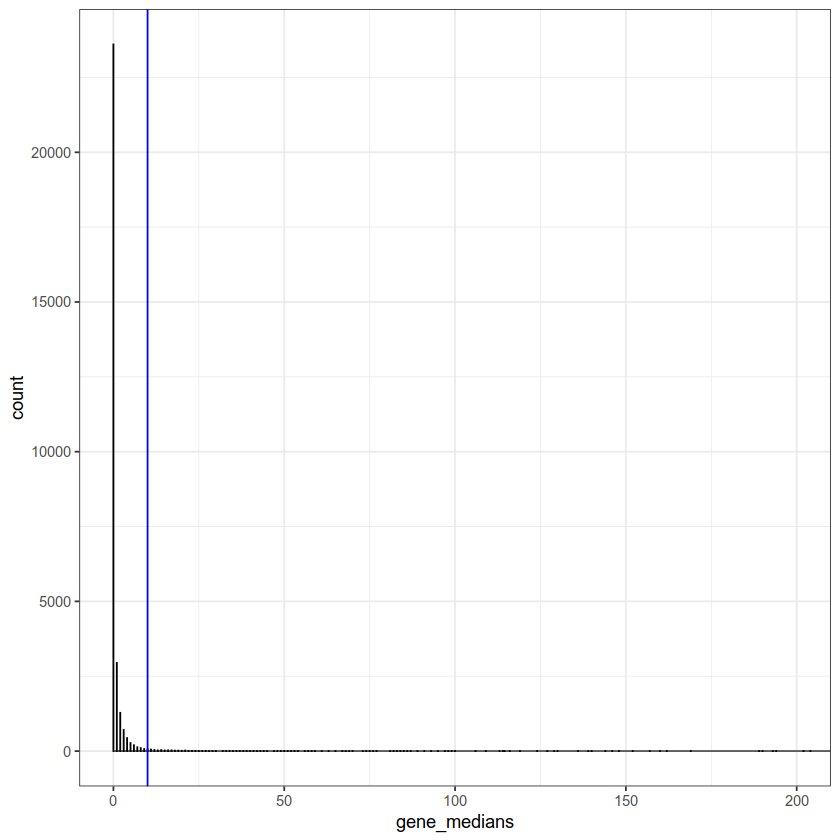

In [11]:
ggplot(median_df, aes(x=gene_medians)) + 
  geom_histogram(color="black", fill="white", bins = 50000) +
  geom_vline(xintercept = 10, color = 'blue') + coord_cartesian(xlim = c(0,200)) +
  theme_bw()

In [12]:
pct_genes_left = function(median_expression, cutoff){
  pct = 100*length(which(median_expression >= cutoff))/length(median_expression)
  return(pct)
}

pct_genes_left(medians, 1)

[1] 21.99564

In [13]:
## removing any genes that are not in top 2000 most variable
filtered_raw_mtx <- filtered_raw_mtx[top_variable_genes,]
filtered_raw_mtx <- filtered_raw_mtx[top_variable_genes,]
filtered_meta_data <- filtered_meta_data[colnames(filtered_raw_mtx),]

In [14]:
### removing genes with medians < 1 keeps 22% of genes -- low expressing genes have noisy expression and confound results ###
##genes_to_keep = as.numeric(medians) >= 1
##filtered_raw_mtx <- filtered_raw_mtx[genes_to_keep,]
##filtered_meta_data <- filtered_meta_data[colnames(filtered_raw_mtx),]

In [15]:
## cells per guide count
guides = unique(filtered_meta_data$guide)

cells_per_guide = vector()
for (i in 1:length(guides)){
    cells_per_guide[i] = length(which(filtered_meta_data$guide == guides[i]))
}

cell_gd_count = data.frame(guide_name = guides, cell_count = cells_per_guide)



Warning message:
“Removed 1 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


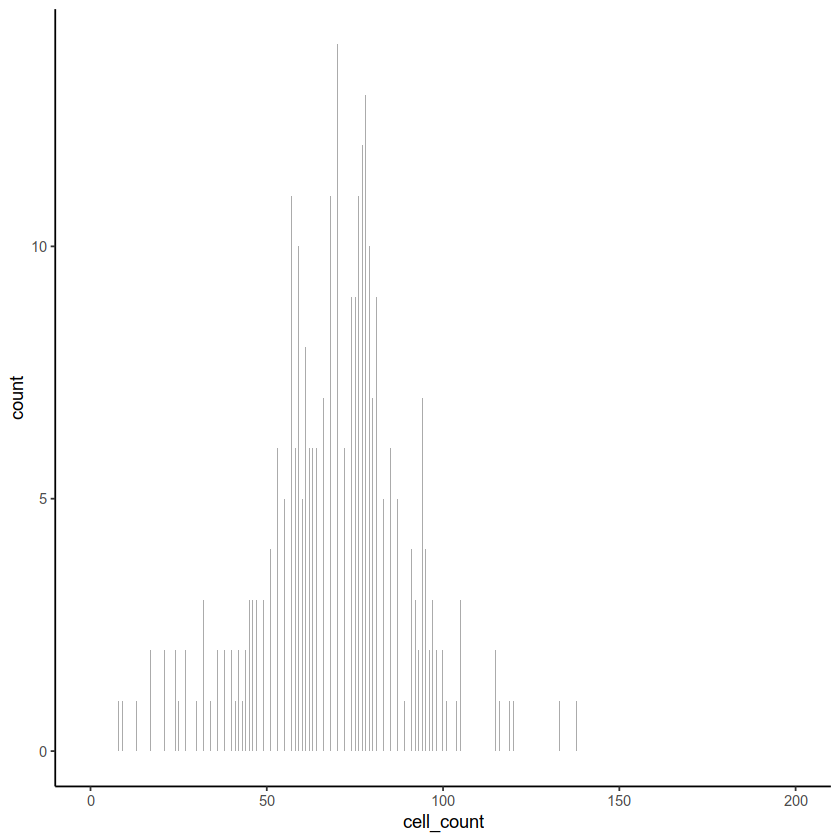

In [16]:
### show distribution of cells per guide

ggplot(cell_gd_count, aes(x=cell_count)) +
geom_histogram(position="identity", alpha=0.5, bins = 1000) + xlim(c(0,200)) +
theme_classic()


In [17]:
### divide expression mtx into a list of mtxs subsetted by guide

mtx_subsetter = function(guide_nm, matrix, meta_data){
    return(matrix[, meta_data$guide == guide_nm])}

guide_subsetted_data = pblapply(X = guides, FUN = mtx_subsetter, 
                                matrix = filtered_raw_mtx, meta_data = filtered_meta_data)

names(guide_subsetted_data) = guides

In [18]:
## control number of cells per guide to be equivalent
## throw out guides with < 30 cells and for the remaining guides sample 30 cells without replacement
fixed_cell_count = 30
guide_subsetted_data = guide_subsetted_data[cells_per_guide >= fixed_cell_count]
cells_to_discard = list()

set.seed(22)
for (i in 1:length(guide_subsetted_data)){
    idx_to_keep = sample(1:ncol(guide_subsetted_data[[i]]), fixed_cell_count, replace = FALSE)
    idx_to_discard = setdiff(1:ncol(guide_subsetted_data[[i]]), idx_to_keep)
    cells_to_discard[[i]] = colnames(guide_subsetted_data[[i]])[idx_to_discard]
    guide_subsetted_data[[i]] = guide_subsetted_data[[i]][,idx_to_keep]
}

cells_to_discard = unlist(cells_to_discard)

In [19]:
idx_to_discard = which(is.na(match(filtered_meta_data$guide, guides[which(cells_per_guide >= fixed_cell_count)])))
filtered_raw_mtx = filtered_raw_mtx[, -idx_to_discard]
filtered_meta_data = filtered_meta_data[-idx_to_discard,]
guides = guides[cells_per_guide >= fixed_cell_count]
cells_per_guide = cells_per_guide[cells_per_guide >= fixed_cell_count]

In [20]:
discard_matched = match(cells_to_discard, colnames(filtered_raw_mtx))
filtered_raw_mtx = filtered_raw_mtx[,-discard_matched]
filtered_meta_data = filtered_meta_data[-discard_matched,]
cells_per_guide = rep(fixed_cell_count, length(cells_per_guide))

In [21]:
## add bkg distribution of guide subsetted mtxs to list
## this is just mtxs where the cells are randomly assigned to each guide
## the bkg distribution of mtxs is made to subtract out number of genes that are expected to have increased or decreased CV when cells assigned randomly to each guide
## Note: the number of cells assigned to each guide is kept the same
set.seed(44)
randomized_cell_order = sample(colnames(filtered_raw_mtx), ncol(filtered_raw_mtx), replace = FALSE)
randomized_filtered_raw_mtx = filtered_raw_mtx[,randomized_cell_order]

designation_vector = mapply(rep, guides, fixed_cell_count, SIMPLIFY = TRUE)
designation_vector = unlist(designation_vector)
designation_vector = as.character(designation_vector)
split_barcodes = split(randomized_cell_order, designation_vector)
mtx_random_splitter = function(barcodes, mtx){return(mtx[,barcodes])}

guide_random_subsetted_data = pblapply(X = split_barcodes, FUN = mtx_random_splitter, mtx = randomized_filtered_raw_mtx)
names(guide_random_subsetted_data) = paste('random', guides, sep = '_')

In [22]:
guide_subsetted_data = c(guide_subsetted_data, guide_random_subsetted_data)

In [23]:
## compare each of the guide subsetted data to the control subsetted data and
## create the following table for each guide:
## gene | CV1 (ctrl) | CV2 (gd) | CV2/CV1 | Increasing or Decreasing CV (ie CV2/CV1 > 1 or CV2/CV1 < 1) | asymptotic test p-value | q-value 


## CV calculator
CV_calculator = function(x){return((sparseMatrixStats::rowSds(x))/(sparseMatrixStats::rowMeans2(x)))}
CVs = pblapply(X = guide_subsetted_data, FUN = CV_calculator)
names(CVs) = names(guide_subsetted_data)

In [24]:
### creating first 4 columns of the table annotated above
gene_means = lapply(guide_subsetted_data, sparseMatrixStats::rowMeans2)
gene_sds = lapply(guide_subsetted_data, sparseMatrixStats::rowSds)
names(gene_means) = names(guide_subsetted_data)
names(gene_sds) = names(guide_subsetted_data)


master_df_list = list()
for (i in 1:length(guide_subsetted_data)){
    if (!startsWith(names(guide_subsetted_data)[i], 'random')){
        master_df_list[[i]] = data.frame(gene = rownames(filtered_raw_mtx), CV_ctrl = CVs[['TuD_NC']], 
                                         CV_gd = CVs[[i]], CV_gdCV_ctrlratio = CVs[[i]]/CVs[['TuD_NC']])
        names(master_df_list)[i] <- names(guide_subsetted_data)[i]
    }
    if (startsWith(names(guide_subsetted_data)[i], 'random')){
        master_df_list[[i]] = data.frame(gene = rownames(filtered_raw_mtx), CV_ctrl = CVs[['TuD_NC']], 
                                         CV_gd = CVs[[i]], CV_gdCV_ctrlratio = CVs[[i]]/CVs[['TuD_NC']])
        names(master_df_list)[i] <- names(guide_subsetted_data)[i]
    }
}



In [25]:
### creating column 5 of the table annotated above
for (i in 1:length(master_df_list)){
    master_df_list[[i]]$gene_status = 'NA'
    master_df_list[[i]]$gene_status[master_df_list[[i]]$CV_gdCV_ctrlratio == 1] = 'No Change'
    master_df_list[[i]]$gene_status[master_df_list[[i]]$CV_gdCV_ctrlratio > 1] = 'Increasing'
    master_df_list[[i]]$gene_status[master_df_list[[i]]$CV_gdCV_ctrlratio < 1] = 'Decreasing'               
}


In [26]:
## performing CV equality aysmptotic test and adding its pval to master_df_list
cells_per_guide = rep(cells_per_guide, 2)
names(cells_per_guide) = names(guide_subsetted_data)
asymp_test_p_vals = as.data.frame(matrix(0, nrow = nrow(filtered_raw_mtx), ncol = length(master_df_list)))


for (i in 1:length(master_df_list)){
    if (!startsWith(names(guide_subsetted_data)[i], 'random')){
        for (j in 1:nrow(filtered_raw_mtx)){
            test = asymptotic_test2(k = 2, n = c(cells_per_guide['TuD_NC'], cells_per_guide[i]), s = c(gene_sds[['TuD_NC']][j], gene_sds[[i]][j]), 
                                    x = c(gene_means[['TuD_NC']][j], gene_means[[i]][j]))
            asymp_test_p_vals[j,i] = test$p_value
        }
    }
    if (startsWith(names(guide_subsetted_data)[i], 'random')){
        for (j in 1:nrow(filtered_raw_mtx)){
            test = asymptotic_test2(k = 2, n = c(cells_per_guide['TuD_NC'], cells_per_guide[i]), s = c(gene_sds[['TuD_NC']][j], gene_sds[[i]][j]), 
                                    x = c(gene_means[['TuD_NC']][j], gene_means[[i]][j]))
            asymp_test_p_vals[j,i] = test$p_value
        }    
    }
    master_df_list[[i]]$p_val = asymp_test_p_vals[,i]
}

In [27]:
## Converting p-values to q-values and adding to master_df_list

for (i in 1:length(master_df_list)){
    q_vals = qvalue(master_df_list[[i]]$p_val, fdr.level = 0.05)
    master_df_list[[i]]$q_val = q_vals$qvalues
}

master_df_list[c('TuD_NC', 'random_TuD_NC')] <- NULL
guide_subsetted_data[c('TuD_NC', 'random_TuD_NC')] <- NULL

In [28]:
## Count number of CV_gdCV_ctrlratio genes > 1 (ie gene_status 'Increasing') with q-val < 0.05
## Count number of CV_gdCV_ctrlratio genes < 1 (ie gene_status 'Decreasing') with q-val < 0.05
filtered_master_df_list = lapply(master_df_list, dplyr::filter, q_val < 0.05)
gene_status_list = lapply(filtered_master_df_list, '[[', 'gene_status')

count_increasing = function(x){length(which(x == 'Increasing'))}
count_decreasing = function(x){length(which(x == 'Decreasing'))}

number_of_increasing_CV_genes = sapply(gene_status_list, count_increasing)
number_of_decreasing_CV_genes = sapply(gene_status_list, count_decreasing)

metric_change_df = data.frame(guide = names(master_df_list), increasing_CV_genes = number_of_increasing_CV_genes, decreasing_CV_genes = number_of_decreasing_CV_genes)

In [29]:
## z-score each guide by the following formula:
## (# of genes increased CV in guide - mean(# of genes increased CV bkg))/sd(# of genes increased CV bkg)
## (# of genes decreased CV in guide - mean(# of genes decreased CV bkg))/sd(# of genes decreased CV bkg)

increasing_random_vals = metric_change_df$increasing_CV_genes[startsWith(rownames(metric_change_df), 'random')]
metric_change_df$z_score_increasing_genes = (metric_change_df$increasing_CV_genes - mean(increasing_random_vals)) / sd(increasing_random_vals)

decreasing_random_vals = metric_change_df$decreasing_CV_genes[startsWith(rownames(metric_change_df), 'random')]
metric_change_df$z_score_decreasing_genes = (metric_change_df$decreasing_CV_genes - mean(decreasing_random_vals)) / sd(decreasing_random_vals)

In [30]:
path = paste0('/home/ssobti/projects/mir_tud/output_data/heterogeneity/', variant, 'metric_change_df.csv')
write.csv(metric_change_df, file = path)

ERROR while rich displaying an object: Error: Discrete value supplied to continuous scale

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler)
7. repr::mime2repr[[mime]](obj)
8. repr_text.default(obj)
9. paste(cap

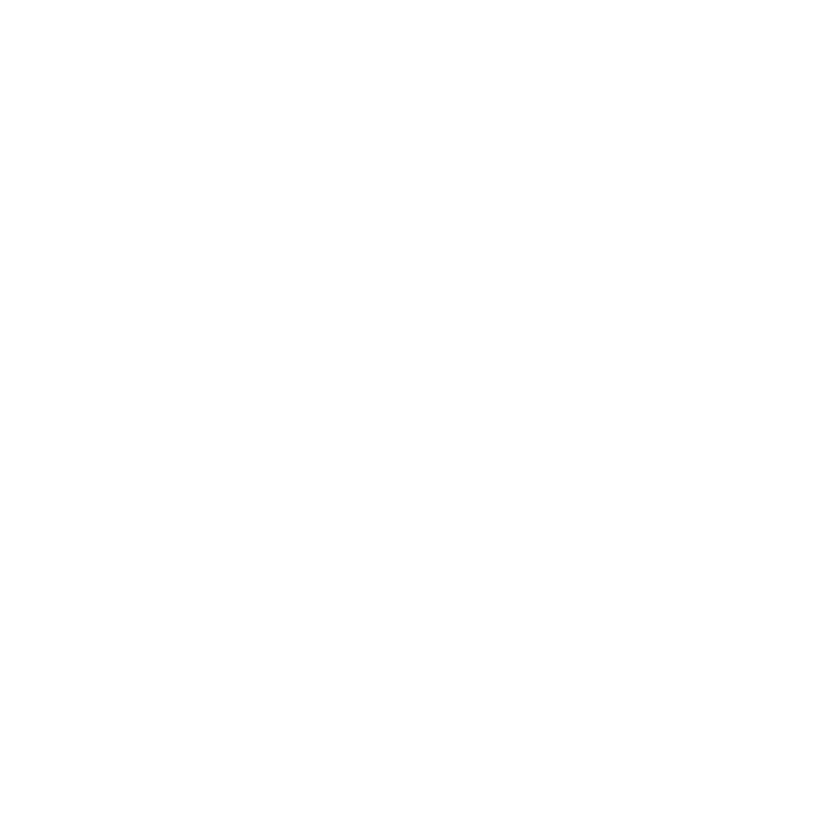

In [31]:
## graph z-scores of increasing CV of each of the guides as boxplot, show top ones. Also show z-scores of decreasing CV

graphing_z_score_df = metric_change_df[!startsWith(rownames(metric_change_df), 'random'),]
graphing_z_score_df = tidyr::pivot_longer(graphing_z_score_df, cols = starts_with("z_score"), names_to = "type", names_prefix = "z_score_", values_to = "z_scores")
graphing_z_score_df = as.data.frame(graphing_z_score_df)
path = paste0('/home/ssobti/projects/mir_tud/output_data/heterogeneity/', variant, 'graphing_z_score_df.csv')
write.csv(graphing_z_score_df, file = path)
graphing_z_score_df = read.csv(path)

library(ggplot2)
library(ggrepel)

ggplot(graphing_z_score_df, aes(x=type, y=z_scores)) + 
    geom_boxplot() + scale_fill_brewer(palette="Blues") + geom_text_repel(aes(y = z_scores, x = type, label = guide), direction = "y") +
    theme_classic() + ylim(min(graphing_z_score_df$z_scores) - 1, max(graphing_z_score_df$z_scores) + 1)

In [32]:
## most importantly see which guides have high z-scores in first graph and low in second 
## also which guides have low z-scores in first graph and high in second 

In [33]:
### the next step could be a comparison between control cells
## and each guide vs comparison between control cells and guides grouped by seed sequence
## analagous to comparing magnitude of CV influence from q25/q75 analysis to q10/q90